In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from registration_utilities import *
from annotation_utilities import *
from metadata import *
from data_manager import *

Setting environment for Precision WorkStation


No vtk


In [3]:
from aligner_v3 import Aligner

In [4]:
lauren_brains = ['LM42_LM37', 'LM94_LM96_LM25', 'LM38', 'LM30new', 'LM27', 'LM37', 'LM22', 'LM32', 'LM17', 'LM48', 'LM31', 'LM95', 'LM41', 'LM84', 'LM40new', 'LM86', 'LM54', 'LM46']

In [8]:
registration_settings

,upstream_warp_id,transform_type,grad_computation_sample_number,grid_search_sample_number,std_tx_um,std_ty_um,std_tz_um,std_theta_xy_degree,surround_weight,regularization_weight,terminate_thresh_trans,terminate_thresh_rot,history_len,max_iter_num,learning_rate_trans,learning_rate_rot,comment
warp_id,,,,,,,,,,,,,,,,,
7,None,rigid,100000,1000,50,50,50,10,inverse,NaN,0.01,0.01,100,5000,1,0.01,"structure registration with surround, no initi..."
20,None,affine,10000,NaN,2000,2000,2000,10,inverse,NaN,NaN,0.01,200,NaN,NaN,NaN,global reg no surr no grid search
17,20,rigid,NaN,10000,NaN,NaN,NaN,NaN,inverse,NaN,0.00,0.01,1000,NaN,NaN,NaN,local reg with surr no grid search
8,None,rigid,100000,10000,200,200,200,30,NaN,NaN,0.00,0.01,NaN,NaN,NaN,NaN,align mid-sagittal planes
109,None,rigid,100000,10000,2000,2000,2000,30,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,global registration given mid-sagittal planes ...


In [ ]:
for brain_name in lauren_brains:
# for brain_name in ['LM42_LM37']:

    brain_f_spec = dict(name=brain_name, vol_type='annotationAsScore', structure='SNR_L', resolution='10.0um')
    brain_m_spec = dict(name='atlasV7', vol_type='score', structure='SNR_L', resolution='10.0um')
    alignment_spec = dict(stack_m=brain_m_spec, stack_f=brain_f_spec, warp_setting=7)

    aligner_parameters = generate_aligner_parameters_v2(alignment_spec=alignment_spec, 
                                                        structures_m=['SNR_L'],
                                                       fixed_structures_are_sided=True,
                                                       fixed_surroundings_have_positive_value=True,
                                                       fixed_use_surround=True)
    
    aligner = Aligner(aligner_parameters['volume_fixed'], 
                      aligner_parameters['volume_moving'], 
                      labelIndexMap_m2f=aligner_parameters['label_mapping_m2f'],
                     invalid_voxel_penalty=0.)

    aligner.set_centroid(centroid_m='structure_centroid', 
                         centroid_f='structure_centroid', 
#                          indices_m=[aligner_parameters['structure_to_label_moving']['SNR_L']]
                        )

    aligner.compute_gradient(smooth_first=True)

    aligner.set_label_weights(label_weights=aligner_parameters['label_weights_m'])

    _, _ = aligner.optimize(tf_type=aligner_parameters['transform_type'], 
                                 max_iter_num=5000,
                                 history_len=100, 
                                 terminate_thresh_trans=.01,
                                terminate_thresh_rot=0.01,
                                 full_lr=np.array([1,1,1,.01,.01,.01]),
                                )

    plot_alignment_results(traj=aligner.Ts, scores=aligner.scores, select_best='max_value')
    
    DataManager.save_alignment_results_v3(aligner=aligner, 
                                          select_best='last_value',
                                          alignment_spec=alignment_spec,
                                          )

Best parameters =
[[ 0.99563895 -0.04410916 -0.08220375 -9.83238376]
 [ 0.04837397  0.99754518  0.05063181  4.66895129]
 [ 0.07976863 -0.05438752  0.99532857  3.77452257]]
Best score = -0.23233115471 , initial score = -0.190689609214


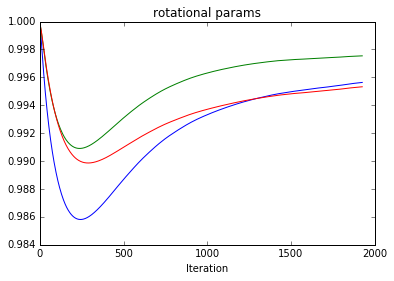

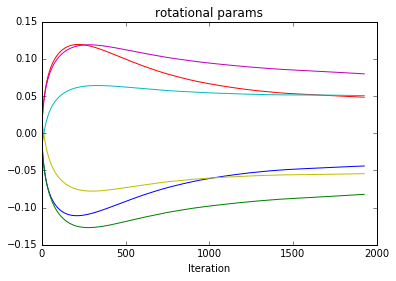

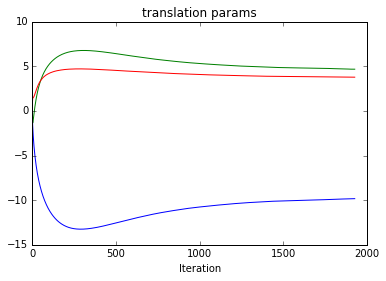

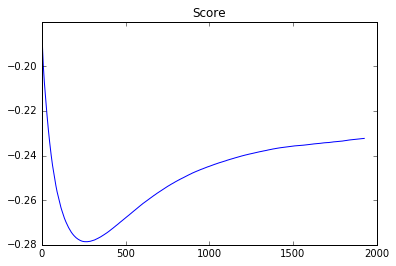

In [13]:
    plot_alignment_results(traj=aligner.Ts, scores=aligner.scores, select_best='last_value')


In [14]:
DataManager.save_alignment_results_v3(aligner=aligner, 
                                      select_best='last_value',
                                      alignment_spec=alignment_spec,
                                      )

aws s3 cp "/home/yuncong/CSHL_registration_parameters/atlasV6/atlasV6_10.0um_scoreVolume_SNR_L_warp7_LM38_10.0um_annotationAsScoreVolume_SNR_L/atlasV6_10.0um_scoreVolume_SNR_L_warp7_LM38_10.0um_annotationAsScoreVolume_SNR_L_parameters.json" "s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV6/atlasV6_10.0um_scoreVolume_SNR_L_warp7_LM38_10.0um_annotationAsScoreVolume_SNR_L/atlasV6_10.0um_scoreVolume_SNR_L_warp7_LM38_10.0um_annotationAsScoreVolume_SNR_L_parameters.json"
return code: 0
aws s3 cp "/home/yuncong/CSHL_registration_parameters/atlasV6/atlasV6_10.0um_scoreVolume_SNR_L_warp7_LM38_10.0um_annotationAsScoreVolume_SNR_L/atlasV6_10.0um_scoreVolume_SNR_L_warp7_LM38_10.0um_annotationAsScoreVolume_SNR_L_scoreHistory.bp" "s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV6/atlasV6_10.0um_scoreVolume_SNR_L_warp7_LM38_10.0um_annotationAsScoreVolume_SNR_L/atlasV6_10.0um_scoreVolume_SNR_L_warp7_LM38_10.0um_annotationAsScoreVolume_SNR_L_scoreHistory.bp"
return code: 0
aw